# Stackoverflow Survey Data Analysis

In this notebook, I analyze data for Stackoverflow developer surveys conducted over nine years 2011 - 2019, and answer some questions. Data is available at: https://insights.stackoverflow.com/survey

## Business Understanding

Using the survey data, I would like to answer the following questions:
    1. What is the trend of top Programming Languages over the years
    2. What is the trend of job satisfcation over the years
    3. What are the Programming Languages gaining/ losing popularity currently
    4. What are the Database environments gaining/ losing popularity currently
    5. What are the Platforms gaining/ losing popularity currently
    6. What are the Web Frameworks gaining/ losing popularity currently

### Loading Libraries and Data

In [1]:
#load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline

In [2]:
#load 2011 data
df_survey_results_11 = pd.read_csv('./Datasets/Stack_Overflow/2011_Stack_Overflow_Survey_Results.csv', encoding = "ISO-8859-1")
#load 2012 data
df_survey_results_12 = pd.read_csv('./Datasets/Stack_Overflow/2012_Stack_Overflow_Survey_Results.csv', encoding = "ISO-8859-1")
#load 2013 data
df_survey_results_13 = pd.read_csv('./Datasets/Stack_Overflow/2013_Stack_Overflow_Survey_Responses.csv', \
                    encoding = "ISO-8859-1", low_memory=False)
#load 2014 data
df_survey_results_14 = pd.read_csv('./Datasets/Stack_Overflow/2014_Stack_Overflow_Survey_Responses.csv', \
                                   encoding = "ISO-8859-1")
#load 2015 data
df_survey_results_15 = pd.read_csv('./Datasets/Stack_Overflow/2015_Stack_Overflow_Developer_Survey_Responses.csv', \
                                   low_memory=False)
#load 2016 data
df_survey_results_16 = pd.read_csv('./Datasets/Stack_Overflow/2016_Stack_Overflow_Survey_Responses.csv')
#load 2017 data
df_survey_results_17 = pd.read_csv('./Datasets/Stack_Overflow/2017_survey_results_public.csv')
#load 2018 data
df_survey_results_18 = pd.read_csv('./Datasets/Stack_Overflow/2018_survey_results_public.csv', low_memory=False)
#load 2019 data
df_survey_results_19 = pd.read_csv('./Datasets/Stack_Overflow/2019_survey_results_public.csv')

### Functions to help in Analysis

In [3]:
# Some of the earlier datasets have response to a question (e.g. 'Which languages are you proficient in?') spanning across
# many columns - with multiplt Unnamed columns following the column with question. This method concatenates the response 
# across columns in one and drops the Unnamed coumns

# one dataset (2015) contains an empty top row
def clean_unnamed(df):
    '''
    Combine mutiple Unnamed columns corresponding to same question. Also remove any empty top rows in dataframe
    INPUT 
        df - a dataframe to clean with Unnamed columns
        
    OUTPUT
        clean_df - a dataframe with no Unnamed columns
    '''
    
    #Check if 1st row needs to be dropped
    all_unnamed = True
    for col in df.columns[:3]:
        if col.lower().find('unnamed:') != 0:
            all_unnamed = False
    
    if all_unnamed:
        df.columns = df.iloc[0]
        df = df.drop(df.index[0])
        
    i = 0
    cols_to_combine = []
    potential_cols_to_combine = []
    for col in df.columns:
        if col.lower().find('unnamed:') == 0:
            # i == 0 is the first column - ignore it
            if i > 0:
                potential_cols_to_combine.append(col)
        else:
            if len(potential_cols_to_combine) > 1 :
                cols_to_combine.append(potential_cols_to_combine)
            potential_cols_to_combine = [col]
            i += 1
            
    clean_df = df
    for col_set in cols_to_combine:
        i = 0
        for col in col_set:
            clean_df[col] = clean_df[col].fillna('')
            if i == 0:
                temp_col = clean_df[col]
                first_col_name = col
                other_cols = []
            else:
                temp_col = temp_col + ";" + clean_df[col]
                other_cols.append(col)
            i += 1
            
        temp_col = temp_col.str.replace('[;]+', ';')
        temp_col = temp_col.str.replace('^; ', '') 
        temp_col = temp_col.str.replace('; $', '') 
        clean_df[first_col_name] = temp_col
        clean_df = clean_df.drop(other_cols, axis=1)
        
    return clean_df

#Combine columns - for some years data for one question has been collected in multiple columns
#(e.g. year 2015)
def concatenate_cols(df, col_name):
    '''
    Combine mutiple columns corresponding to same question.
    INPUT 
        df - a dataframe with columns to combine
        col_name - partial name of column to combine
        
    OUTPUT
        clean_df - a dataframe with combined column
    '''        
    cols_to_combine = []
    for col in df.columns:
        if col.lower().find(col_name.lower()) == 0:
            cols_to_combine.append(col)
            
    clean_df = df
    i = 0
    for col in cols_to_combine:
        clean_df[col] = clean_df[col].fillna('')
        if i == 0:
            temp_col = clean_df[col]
        else:
            temp_col = temp_col + ";" + clean_df[col]
        i += 1

    temp_col = temp_col.str.replace('[;]+', ';')
    temp_col = temp_col.str.replace('^; ', '') 
    temp_col = temp_col.str.replace('; $', '') 
    clean_df[col_name] = temp_col
    clean_df = clean_df.drop(cols_to_combine, axis=1)
        
    return clean_df

In [4]:
# for year 2014, there is no job satisfaction
def get_common_job_sat_values (col_looking_for_job, col_visit_board, col_career_profile):
    """
    Create job satisfaction values along with percentage of users from three columns - Looking for Job, 
    Visit Job borad frequency, Have a job profile
    Inputs:
        col_looking_for_job - col with information of user looking for job or not
        col_visit_board
    """
    
    all_values = []
    i = 0
    for looking_for_job in col_looking_for_job:
        looking_for_job = looking_for_job.strip().lower()
        visit_board = col_visit_board[i].strip().lower()
        career_profile = col_career_profile[i].strip().lower()
        i += 1
        if looking_for_job == '':
            val = ''
        else:
            val = 'neither satisfied nor dissatisfied'
            if looking_for_job == 'no':
                if visit_board == 'never' and career_profile == 'no thank you':
                    val = 'extremely satisfied'
                elif visit_board == 'never' or career_profile == 'no thank you':
                    val = 'slightly satisfied'
            else:
                if visit_board == 'daily' and career_profile == 'yes':
                    val = 'extremely dissatisfied'
                elif visit_board == 'daily' or career_profile == 'yes':
                    val = 'slightly dissatisfied'
        
        if val != '':
            all_values.append(val)
    
    count_dict = collections.Counter(all_values)
    most_common = count_dict.most_common()
    most_common_as_percent = [(lang, round((count * 100/len(all_values)), 2)) for lang, count in most_common]
    
    return most_common_as_percent

#create data frames for satisfaction
def create_sat_data_frame(percent, year):
    """
    Create data frame from array of tupples and year
    inputs:
        percent - array of tupples with Name and percent values
        year - year of the values
    """
    sat_pd = pd.DataFrame(percent)
    sat_pd = sat_pd.transpose()
    sat_pd.columns = sat_pd.iloc[0]
    sat_pd = sat_pd.drop(sat_pd.index[0])
    sat_pd.insert(0, 'year', [year])
    return sat_pd

In [5]:
# get top values
def get_top_values(col, top_n=10):
    """
    Returns array of tupples for top options and their percentage in a data frame column with multiple options seperated by ';'
    inputs:
        col - column with mutiple selection data.
        top_n - top n values to return along with percentage. Defaults to 10.
    
    """
    # as langauges were merged with framework, technology questiong in some years - ignoring them
    ignore_arr = ['android', 'angularjs', 'cloud (aws, gae, azure, etc.)', 'none', 'others', \
                  'mongodb', 'node.js', 'reactjs', 'redis', 'wordpress', 'arduino / raspberry pi', \
                  'jquery', 'lamp', 'ios', 'sql server', 'response', 'other (please specify)', \
                  "i don't have a job", \
                  'i wish i had a job!']
    
    replace_dict = {'bash':'bash/shell/powershell',
                    'bash/shell':'bash/shell/powershell',
                    'c++11':'c++',
                    'css':'html/css',
                    'html':'html/css',
                    'html5':'html/css',
                    'objective c':'objective-c',
                    'visual basic':'vb',
                    'visual basic 6':'vb',
                    'so happy it hurts':'extremely satisfied',
                    'i enjoy going to work':'slightly satisfied',
                    'it pays the bills':'neither satisfied nor dissatisfied',
                    "i'm not happy in my job":'slightly dissatisfied',
                    'fml':'extremely dissatisfied',
                    'moderately satisfied':'slightly satisfied',
                    'moderately dissatisfied':'slightly dissatisfied',
                    '0.0':'extremely dissatisfied',
                    '1.0':'extremely dissatisfied',
                    '2.0':'slightly dissatisfied',
                    '3.0':'slightly dissatisfied',
                    '4.0':'neither satisfied nor dissatisfied',
                    '5.0':'neither satisfied nor dissatisfied',
                    '6.0':'neither satisfied nor dissatisfied',
                    '7.0':'slightly satisfied',
                    '8.0':'slightly satisfied',
                    '9.0':'extremely satisfied',
                    '10.0':'extremely satisfied',
                    'i hate my job':'extremely dissatisfied',
                    'hate my job':'extremely dissatisfied',
                    'very dissatisfied':'extremely dissatisfied',
                    "i'm somewhat dissatisfied with my job":'slightly dissatisfied',
                    "i'm neither satisfied nor dissatisfied":'neither satisfied nor dissatisfied',
                    "i'm neither satisfied nor dissatisfied with my job":\
                    'neither satisfied nor dissatisfied',
                    'its a paycheck':'neither satisfied nor dissatisfied',
                    "it's a paycheck":'neither satisfied nor dissatisfied',
                    "i'm somewhat satisfied with my job":'slightly satisfied',
                    'i love my job':'extremely satisfied',
                    'love my job':'extremely satisfied',
                    'very satisfied':'extremely satisfied'
                   }
    
    all_values = []
    non_blank_values = 0
    for val in col:
        arr_to_extend = []
        if isinstance(val, float):
            val = str(val)
        for val_split in val.split(';'):
            val_append = val_split.strip().lower()
            if val_append != '' and val_append not in ignore_arr:
                if val_append in replace_dict:
                    val_append = replace_dict[val_append]
                if val_append not in arr_to_extend:
                    arr_to_extend.append(val_append)

        if len(arr_to_extend) > 0:
            non_blank_values += 1
            all_values.extend(arr_to_extend)
            
    count_dict = collections.Counter(all_values)
    most_common = count_dict.most_common(top_n)
    most_common_as_percent = [(lang, round((count * 100)/non_blank_values, 2)) \
                              for lang, count in most_common]
    
    return most_common_as_percent

# get top values
def get_top_values_without_ignore_or_replace(col, top_n=10):
    """
    Returns array of tupples for top options and their percentage in a data frame column with multiple options seperated by ';'
    inputs:
        col - column with mutiple selection data.
        top_n - top n values to return along with percentage. Defaults to 10.
    
    """
    all_values = []
    non_blank_values = 0
    for val in col:
        arr_to_extend = []
        if isinstance(val, float):
            val = str(val)
        for val_split in val.split(';'):
            val_append = val_split.strip()
            if val_append != '':
                if val_append not in arr_to_extend:
                    arr_to_extend.append(val_append)

        if len(arr_to_extend) > 0:
            non_blank_values += 1
            all_values.extend(arr_to_extend)
            
    count_dict = collections.Counter(all_values)
    most_common = count_dict.most_common(top_n)
    most_common_as_percent = [(val, round((count * 100)/non_blank_values, 2)) for val, count in most_common]
    
    return most_common_as_percent

In [6]:
def plot_values(df, col_to_plot, col_to_count, title='', xlabel='', ylabel='', width=6.4, height=4.8):
    """
    Plot a bar chart for unique values in a data frame column.
    inputs:
        df - Data frame
        col_to_plot - Name of data frame column to plot
        col_to_count - Name of column to use for counting
        title - Title of Plot. Defaults to ''
        xlabel - x axis label. Defaults to ''
        ylabel - y axis label. Defaults to ''
        width - width of plot. Defaults to 6.4
        height - height of plot. Defaults to 4.8
    """
    series_to_plot = df.groupby([col_to_plot])[col_to_count].count()*100/df.shape[0]
    series_to_plot.sort_values(inplace=True)
    ax = series_to_plot.plot.barh(figsize=(width, height))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.3, i.get_y()+.15, str(round(i.get_width(), 2))+'%', fontsize=10, color='dimgrey')
    plt.show()
    
def plot_top_values(top_values, title='', xlabel='', ylabel='', width=6.4, height=4.8):
    """
    Plot a bar chart from an array of tupples.
    inputs:
        top_values - array of tupples to plot
        title - Title of Plot. Defaults to ''
        xlabel - x axis label. Defaults to ''
        ylabel - y axis label. Defaults to ''
        width - width of plot. Defaults to 6.4
        height - height of plot. Defaults to 4.8
    """
    top_pd = pd.DataFrame(top_values)
    top_pd = top_pd.sort_values(by=[1])
    ax = top_pd.plot.barh(x=0, y=1, figsize=(width, height))
    ax.legend().set_visible(False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_width()+.3, i.get_y()+.15, str(round(i.get_width(), 2))+'%', fontsize=10, color='dimgrey')
    plt.show()

## Data Understanding

Below we try to get basic understanding of the data

In [7]:
df_survey_results_11.head()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,How likely is it that a recommendation you make will be acted upon?,What is your involvement in purchasing? You can choose more than 1.,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,"In the last 12 months, how much money have you spent on personal technology-related purchases?",Which of our sites do you frequent most?
0,Response,Response,Response,Response,Response,Response,Response,Response,Influencer,Recommender,...,AppleTV,iPad,Other netbook,PS3,Xbox,Wii,Other gaming system,other (please specify),Response,Response
1,Africa,NaN,< 20,<2,Consulting,Start Up (1-25),Web Application Developer,Not in a million years,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<$100,NaN
2,Other Europe,NaN,25-29,41310,Software Products,Mature Small Business (25-100),Server Programmer,It's been known to happen,NaN,NaN,...,NaN,NaN,Other netbook,NaN,NaN,NaN,NaN,NaN,$251-$500,Stack Overflow
3,India,NaN,25-29,41435,Software Products,Mid Sized (100-999),Server Programmer,Unless it's stoopid it gets done,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Germany,NaN,< 20,41310,Foundation / Non-Profit,Student,Student,It's been known to happen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Wii,Other gaming system,NaN,"$501-$1,000",Stack Overflow


In [8]:
df_survey_results_11.describe()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,How likely is it that a recommendation you make will be acted upon?,What is your involvement in purchasing? You can choose more than 1.,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,"In the last 12 months, how much money have you spent on personal technology-related purchases?",Which of our sites do you frequent most?
count,2814,1030,2730,2730,2730,2647,2647,2611,1362,1497,...,117,395,502,377,598,825,315,219,2506,2533
unique,20,52,9,5,13,7,14,6,1,1,...,1,1,1,1,1,1,1,148,8,8
top,United States of America,California,25-29,11,Software Products,Start Up (1-25),Web Application Developer,It's been known to happen,Influencer,Recommender,...,AppleTV,iPad,Other netbook,PS3,Xbox,Wii,Other gaming system,iPod Touch,"$1,001-$2,000",Stack Overflow
freq,1037,122,831,1044,814,745,1066,1060,1362,1497,...,117,395,502,377,598,825,315,27,569,2230


In [9]:
df_survey_results_12.head()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),Unnamed: 8,Unnamed: 9,...,Please rate the advertising you've seen on Stack Overflow,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,Which of our sites do you frequent most?,Unnamed: 74
0,Response,Response,Response,Response,Response,Response,Response,Influencer,Recommender,Approver,...,The ads are relevant,The ads are entertaining,The ads are Informative,I click on ads that interest me,I've taken a trial/purchased a product from ads,What ads? I use an ad blocker,Open-Ended Response,Response,Response,Other Stack Exchange (please specify)
1,India,NaN,20-24,<2,Consulting,"Fortune 1000 (1,000+)",Server Programmer,Influencer,Recommender,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Germany,NaN,25-29,<2,Other,Mature Small Business (25-100),Embedded Application Developer,NaN,Recommender,NaN,...,Neutral,Agree,Agree,Strongly Disagree,Strongly Disagree,Disagree,NaN,Don't have an account,Stack Overflow,NaN
3,United Kingdom,NaN,20-24,41070,Finance / Banking,Mature Small Business (25-100),Web Application Developer,Influencer,Recommender,NaN,...,Neutral,Neutral,Neutral,Neutral,Neutral,Strongly Agree,NaN,1,Stack Overflow,NaN
4,France,NaN,20-24,40944,Software Products,Mature Small Business (25-100),Embedded Application Developer,NaN,NaN,NaN,...,Agree,Strongly Disagree,Disagree,Disagree,Strongly Disagree,Disagree,None !,Don't have an account,Stack Overflow,NaN


In [10]:
df_survey_results_12.describe()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,What is your involvement in purchasing products or services for the company you work for? (You can choose more than one),Unnamed: 8,Unnamed: 9,...,Please rate the advertising you've seen on Stack Overflow,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,Which of our sites do you frequent most?,Unnamed: 74
count,6244,1776,5965,5965,5965,5738,5738,2555,2773,976,...,5157,5162,5160,5173,5150,5108,1981,5143,5197,253
unique,21,54,9,5,13,7,15,1,1,1,...,6,6,6,6,6,6,1465,12,8,184
top,United States of America,California,25-29,40944,Software Products,Start Up (1-25),Web Application Developer,Influencer,Recommender,Approver,...,Neutral,Neutral,Neutral,Agree,Strongly Disagree,Strongly Disagree,None,1,Stack Overflow,Gaming
freq,1785,256,1914,1934,1883,1762,2427,2555,2773,976,...,2186,2629,2667,2164,2139,2131,93,756,4627,17


In [11]:
df_survey_results_13.head()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,How many people work for your company?,Which of the following best describes your occupation?,"Including yourself, how many developers are employed at your company?",How large is the team that you work on?,What other departments / roles do you interact with regularly?,...,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,Unnamed: 125,Unnamed: 126,Unnamed: 127
0,Response,Response,Response,Response,Response,Response,Response,Response,Response,System Administrators,...,The ads are Informative,I click on ads that interest me,I've taken a trial/purchased a product from ads,What ads? I use an ad blocker,Open-Ended Response,Response,Read other people's questions to solve my prob...,Ask questions to solve problems,Answer questions I know the answer to,Other (please specify)
1,United Kingdom,NaN,35-39,6/10/2013,Finance / Banking,101-999,Enterprise Level Services,100,4/8/2013,System Administrators,...,Neutral,Neutral,Neutral,Neutral,NaN,Don't have an account,Read other people's questions to solve my prob...,NaN,NaN,NaN
2,United States of America,Oregon,25-29,6/10/2013,Retail,101-999,Back-End Web Developer,6/15/2013,4/8/2013,System Administrators,...,Neutral,Agree,Disagree,Neutral,"StackOverflow themselves, Careers 2.0 (SO also...",1,Read other people's questions to solve my prob...,Ask questions to solve problems,Answer questions I know the answer to,NaN
3,United States of America,Wisconsin,51-60,11,Software Products,26-100,Enterprise Level Services,6/15/2013,Just me!,System Administrators,...,Neutral,Strongly Disagree,Strongly Disagree,Strongly Disagree,don't recall seeing ads on Stack Overflow,Don't have an account,Read other people's questions to solve my prob...,NaN,NaN,NaN
4,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_survey_results_13.describe()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you currently work in?,How many people work for your company?,Which of the following best describes your occupation?,"Including yourself, how many developers are employed at your company?",How large is the team that you work on?,What other departments / roles do you interact with regularly?,...,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,Unnamed: 125,Unnamed: 126,Unnamed: 127
count,9742,3160,9435,9437,9437,8219,8219,7834,7942,4137,...,7466,7497,7482,7424,2758,7433,7057,4923,5926,602
unique,21,53,9,5,13,7,15,7,6,1,...,6,6,6,6,1726,12,1,1,1,588
top,United States of America,California,25-29,11,Software Products,1/25/2013,Full-Stack Web Developer,1/5/2013,4/8/2013,System Administrators,...,Neutral,Neutral,Strongly Disagree,Strongly Disagree,None,1000,Read other people's questions to solve my prob...,Ask questions to solve problems,Answer questions I know the answer to,Review
freq,3181,471,2594,3047,2930,2706,2387,3021,2672,4137,...,4562,2692,3242,2180,197,969,7057,4923,5926,5


In [13]:
df_survey_results_14.head()

,What Country do you live in?,Unnamed: 1,Which US State or Territory do you live in?,How old are you?,What is your gender?,How many years of IT/Programming experience do you have?,Which of the following best describes your occupation?,"Including bonus, what is your annual compensation in USD?",How would you best describe the industry you currently work in?,How many developers are employed at your company?,...,Did you participate in the Apptivate contest?,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,How often do you find solutions to your programming problems on Stack Overflow without asking a new question?
0,Response,Other (please specify),Response,Response,Response,Response,Response,Response,Response,Response,...,Response,Open-Ended Response,Response,Read other people's questions to solve my prob...,Ask questions to solve problems,Answer questions I know the answer to,Looking for a job,Build my online reputation,Other (please specify),Response
1,India,NaN,NaN,30-34,Female,6/10/2014,Back-End Web Developer,"$20,000 - $40,000",Finance / Banking,100,...,No,NaN,500,Read other people's questions to solve my prob...,Ask questions to solve problems,NaN,NaN,NaN,NaN,Almost Always
2,Thailand,NaN,NaN,20-24,Male,<2,Back-End Web Developer,Student / Unemployed,Healthcare,NaN,...,NaN,NaN,Don't have an account,Read other people's questions to solve my prob...,NaN,NaN,NaN,NaN,NaN,NaN
3,Iran,NaN,NaN,25-29,Male,6/10/2014,Desktop Software Developer,"<$20,000",Not Currently Employed,1/5/2014,...,No,Tehcodez,1,Read other people's questions to solve my prob...,NaN,NaN,NaN,NaN,NaN,Almost Always
4,Ukraine,NaN,NaN,< 20,Male,<2,Student,Student / Unemployed,Student,NaN,...,NaN,NaN,50,Read other people's questions to solve my prob...,Ask questions to solve problems,NaN,NaN,NaN,NaN,Almost Always


In [14]:
df_survey_results_14.describe()

,What Country do you live in?,Unnamed: 1,Which US State or Territory do you live in?,How old are you?,What is your gender?,How many years of IT/Programming experience do you have?,Which of the following best describes your occupation?,"Including bonus, what is your annual compensation in USD?",How would you best describe the industry you currently work in?,How many developers are employed at your company?,...,Did you participate in the Apptivate contest?,What advertisers do you remember seeing on Stack Overflow?,What is your current Stack Overflow reputation?,How do you use Stack Overflow?,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,How often do you find solutions to your programming problems on Stack Overflow without asking a new question?
count,7644,1,2109,7347,7347,7347,7347,6901,7220,6398,...,6195,1632,6284,5950,4074,4927,587,2610,266,6259
unique,97,1,52,9,4,5,16,11,16,7,...,4,1097,12,1,1,1,1,1,262,6
top,United States,Other (please specify),California,25-29,Male,2/5/2014,Full-Stack Web Developer,Student / Unemployed,Software Products,1/5/2014,...,No,None,1,Read other people's questions to solve my prob...,Ask questions to solve problems,Answer questions I know the answer to,Looking for a job,Build my online reputation,Learning,Almost Always
freq,2128,1,286,2034,6864,2405,1966,1147,2021,2131,...,5791,107,843,5950,4074,4927,587,2610,3,3718


In [15]:
df_survey_results_15.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Select all that apply,Unnamed: 9,...,Unnamed: 212,Unnamed: 213,Select all that apply.7,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221
0,Country,Age,Gender,Tabs or Spaces,Years IT / Programming Experience,Occupation,Desktop Operating System,Desktop Operating System: write-in,Current Lang & Tech: Android,Current Lang & Tech: Arduino,...,Why use Stack Overflow: I don't use Stack Over...,How often are Stack Overflow's answers helpful,Why answer: Help a programmer in need,Why answer: Help future programmers,Why answer: Demonstrate expertise,Why answer: Self promotion,Why answer: Sense of responsibility to developers,Why answer: No idea,Why answer: I don't answer and I don't want to,Why answer: I don't answer but I want to
1,Croatia,25-29,Male,Tabs,2 - 5 years,Back-end web developer,Ubuntu,NaN,NaN,NaN,...,NaN,Usually,NaN,NaN,It feels good to demonstrate my expertise.,Demonstrating my expertise will benefit me,I feel a sense of responsibility to the develo...,NaN,NaN,NaN
2,France,20-24,Male,Spaces,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,...,NaN,Usually,NaN,My answer will help lots of people who have th...,It feels good to demonstrate my expertise.,NaN,NaN,NaN,NaN,NaN
3,India,20-24,Male,Tabs,1 - 2 years,Back-end web developer,Windows 7,NaN,NaN,NaN,...,NaN,Rarely,NaN,NaN,NaN,Demonstrating my expertise will benefit me,NaN,NaN,NaN,NaN
4,Latvia,25-29,Male,It depends,6 - 10 years,Back-end web developer,Ubuntu,NaN,NaN,NaN,...,NaN,Usually,It feels good to help a programmer in need,My answer will help lots of people who have th...,It feels good to demonstrate my expertise.,Demonstrating my expertise will benefit me,I feel a sense of responsibility to the develo...,NaN,NaN,NaN


In [16]:
df_survey_results_15.describe()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Select all that apply,Unnamed: 9,...,Unnamed: 212,Unnamed: 213,Select all that apply.7,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221
count,25280,25832,25745,25808,24828,20852,21981,791,4111,1627,...,206,16394,10231,8664,4827,3319,5176,1023,703,5701
unique,157,10,5,5,6,25,11,325,2,2,...,2,6,2,2,2,2,2,2,2,2
top,United States,25-29,Male,Tabs,2 - 5 years,Full-stack web developer,Windows 7,Arch Linux,Android,Arduino / Raspberry Pi,...,I don't really use Stack Overflow. I just take...,Usually,It feels good to help a programmer in need,My answer will help lots of people who have th...,It feels good to demonstrate my expertise.,Demonstrating my expertise will benefit me,I feel a sense of responsibility to the develo...,I have no idea why I answer but I do it anyway,"I don't answer much (or at all), and I don't w...","I don't answer much (or at all), but I want to..."
freq,4745,7365,23699,11604,8037,6765,7700,101,4110,1626,...,205,12453,10230,8663,4826,3318,5175,1022,702,5700


In [17]:
df_survey_results_16.head()

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21378,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,...,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn
4,30280,Facebook,Afghanistan,Southern Asia,Central Asia,> 60,65.0,Prefer not to disclose,Developer; Engineer; Programmer; Sr. Developer...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_survey_results_16.describe()

,Unnamed: 0,age_midpoint,experience_midpoint,salary_midpoint,big_mac_index,programming_ability
count,56030.000000,55336.000000,49520.000000,41742.000000,48825.000000,46982.000000
mean,28014.500000,29.621286,6.640145,53952.973025,3.907442,7.094547
std,16174.612128,9.108102,4.446157,46518.823875,1.120232,1.766312
min,0.000000,16.000000,0.500000,5000.000000,1.530000,1.000000
25%,14007.250000,22.000000,3.500000,15000.000000,3.410000,6.000000
50%,28014.500000,27.000000,3.500000,45000.000000,4.220000,7.000000
75%,42021.750000,32.000000,13.000000,75000.000000,4.930000,8.000000
max,56029.000000,65.000000,13.000000,210000.000000,6.440000,10.000000


In [19]:
df_survey_results_17.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_survey_results_17.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000


In [21]:
df_survey_results_18.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [22]:
df_survey_results_18.describe()

,Respondent,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,AssessJob7,AssessJob8,AssessJob9,...,JobEmailPriorities6,JobEmailPriorities7,ConvertedSalary,AdsPriorities1,AdsPriorities2,AdsPriorities3,AdsPriorities4,AdsPriorities5,AdsPriorities6,AdsPriorities7
count,98855.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,66985.000000,...,46213.00000,46213.000000,4.770200e+04,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000,60479.000000
mean,50822.971635,6.397089,6.673524,5.906875,4.065791,3.953243,4.407196,5.673181,4.225200,7.640009,...,4.97425,4.836388,9.578086e+04,2.726880,3.805784,3.340945,3.782470,4.383604,5.138809,4.821459
std,29321.650410,2.788428,2.531202,2.642734,2.541196,2.520499,2.502069,2.923998,2.507411,2.407457,...,1.86063,1.659844,2.023482e+05,1.881078,1.821323,1.673485,1.844864,1.931746,1.853249,1.874895
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,25443.500000,4.000000,5.000000,4.000000,2.000000,2.000000,2.000000,3.000000,2.000000,6.000000,...,4.00000,4.000000,2.384400e+04,1.000000,2.000000,2.000000,2.000000,3.000000,4.000000,3.000000
50%,50823.000000,7.000000,7.000000,6.000000,4.000000,3.000000,4.000000,6.000000,4.000000,8.000000,...,5.00000,5.000000,5.507500e+04,2.000000,4.000000,3.000000,4.000000,5.000000,6.000000,5.000000
75%,76219.500000,9.000000,9.000000,8.000000,6.000000,6.000000,6.000000,8.000000,6.000000,10.000000,...,7.00000,6.000000,9.300000e+04,4.000000,5.000000,5.000000,5.000000,6.000000,7.000000,7.000000
max,101592.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,7.00000,7.000000,2.000000e+06,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [23]:
df_survey_results_19.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [24]:
df_survey_results_19.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


### Data Cleaning

Removing Unnamed columns and rows.

In [25]:
df_survey_results_11 = clean_unnamed(df_survey_results_11)
df_survey_results_12 = clean_unnamed(df_survey_results_12)
df_survey_results_13 = clean_unnamed(df_survey_results_13)
df_survey_results_14 = clean_unnamed(df_survey_results_14)
df_survey_results_15 = clean_unnamed(df_survey_results_15)

#Concatenate results from multiple columns in one
df_survey_results_15 = concatenate_cols(df_survey_results_15, 'Current Lang & Tech:')

## Prepare Data

Read in the relevant columns required for analysis. Filling NaNs with blanks where requried.

In [26]:
lang_col_11 = df_survey_results_11['Which languages are you proficient in?']
lang_col_12 = df_survey_results_12['Which languages are you proficient in?']
lang_col_13 = df_survey_results_13['Which of the following languages or technologies have you used significantly in the past year?']
lang_col_14 = df_survey_results_14['Which of the following languages or technologies have you used significantly in the past year?']
lang_col_15 = df_survey_results_15['Current Lang & Tech:']

# Filling NaN with blanks
lang_col_16 = df_survey_results_16['tech_do'].fillna('')
lang_col_17 = df_survey_results_17['HaveWorkedLanguage'].fillna('')
lang_col_18 = df_survey_results_18['LanguageWorkedWith'].fillna('')
lang_col_19 = df_survey_results_19['LanguageWorkedWith'].fillna('')

In [27]:
#Create clean satisfaction cols to work with
sat_col_11 = df_survey_results_11['Please rate your job/career satisfaction'].fillna('')
sat_col_12 = df_survey_results_12['What best describes your career / job satisfaction? '].fillna('')
sat_col_13 = df_survey_results_13['What best describes your career / job satisfaction?'].fillna('')
looking_job_col_14 = df_survey_results_14['Are you currently looking for a job or open to new opportunities?'].fillna('')
visit_job_board_14 = df_survey_results_14['How often do you visit job boards?'].fillna('')
stack_job_profile_14 = df_survey_results_14['Do you have a Stack Overflow Careers 2.0 Profile?'].fillna('')
sat_col_15 = df_survey_results_15['Job Satisfaction'].fillna('')
sat_col_16 = df_survey_results_16['job_satisfaction'].fillna('')
sat_col_17 = df_survey_results_17['JobSatisfaction'].fillna('')
sat_col_18 = df_survey_results_18['JobSatisfaction'].fillna('')
sat_col_19 = df_survey_results_19['JobSat'].fillna('')

In [28]:
lang_worked_with_19 = df_survey_results_19['LanguageWorkedWith']
lang_desired_to_work_19 = df_survey_results_19['LanguageDesireNextYear']
database_worked_with_19 = df_survey_results_19['DatabaseWorkedWith']
database_desired_to_work_19 = df_survey_results_19['DatabaseDesireNextYear']
platform_worked_with_19 = df_survey_results_19['PlatformWorkedWith']
platform_desired_to_work_19 = df_survey_results_19['PlatformDesireNextYear']
webframe_worked_with_19 = df_survey_results_19['WebFrameWorkedWith']
webframe_desired_to_work_19 = df_survey_results_19['WebFrameDesireNextYear']

## Data Modeling

Below we get the top languages across the years along with percentage of users using the language. We get the percentage of users with various levels of job satifaction. We also get top languages, database environments, platforms and web frameworks.

In [29]:
top_langs_11 = get_top_values(lang_col_11)
top_langs_12 = get_top_values(lang_col_12)
top_langs_13 = get_top_values(lang_col_13)
top_langs_14 = get_top_values(lang_col_14)
top_langs_15 = get_top_values(lang_col_15)
top_langs_16 = get_top_values(lang_col_16)
top_langs_17 = get_top_values(lang_col_17)
top_langs_18 = get_top_values(lang_col_18)
top_langs_19 = get_top_values(lang_col_19)

In [30]:
sat_percent_11 = get_top_values(sat_col_11)
sat_percent_12 = get_top_values(sat_col_12)
sat_percent_13 = get_top_values(sat_col_13)
sat_percent_14 = get_common_job_sat_values(looking_job_col_14, visit_job_board_14, stack_job_profile_14)
sat_percent_15 = get_top_values(sat_col_15)
sat_percent_16 = get_top_values(sat_col_16)
sat_percent_17 = get_top_values(sat_col_17)
sat_percent_18 = get_top_values(sat_col_18)
sat_percent_19 = get_top_values(sat_col_19)

In [31]:
pd_sat_11 = create_sat_data_frame(sat_percent_11, 2011)
pd_sat_12 = create_sat_data_frame(sat_percent_12, 2012)
pd_sat_13 = create_sat_data_frame(sat_percent_13, 2013)
pd_sat_14 = create_sat_data_frame(sat_percent_14, 2014)
pd_sat_15 = create_sat_data_frame(sat_percent_15, 2015)
pd_sat_16 = create_sat_data_frame(sat_percent_16, 2016)
pd_sat_17 = create_sat_data_frame(sat_percent_17, 2017)
pd_sat_18 = create_sat_data_frame(sat_percent_18, 2018)
pd_sat_19 = create_sat_data_frame(sat_percent_19, 2019)

In [32]:
combined_sat_data = pd.concat([pd_sat_11, pd_sat_12, pd_sat_13, pd_sat_14, pd_sat_15, pd_sat_16, pd_sat_17, \
                               pd_sat_18, pd_sat_19], ignore_index=True, sort=False)

cols = ['year', 'extremely dissatisfied', 'slightly dissatisfied', 'neither satisfied nor dissatisfied', \
        'slightly satisfied', 'extremely satisfied']

combined_sat_data = combined_sat_data[cols]

In [33]:
top_lang_worked_with_19 = get_top_values_without_ignore_or_replace(lang_worked_with_19, top_n=1000)
top_lang_desired_to_work_19 = get_top_values_without_ignore_or_replace(lang_desired_to_work_19, top_n=1000)
top_database_worked_with_19 = get_top_values_without_ignore_or_replace(database_worked_with_19, top_n=1000)
top_database_desired_to_work_19 = get_top_values_without_ignore_or_replace(database_desired_to_work_19, top_n=1000)
top_platform_worked_with_19 = get_top_values_without_ignore_or_replace(platform_worked_with_19, top_n=1000)
top_platform_desired_to_work_19 = get_top_values_without_ignore_or_replace(platform_desired_to_work_19, top_n=1000)
top_webframe_worked_with_19 = get_top_values_without_ignore_or_replace(webframe_worked_with_19, top_n=1000)
top_webframe_desired_to_work_19 = get_top_values_without_ignore_or_replace(webframe_desired_to_work_19, top_n=1000)

## Evaluate the Results

Below we visualize the results of our analysis.

### Top Languages over the years

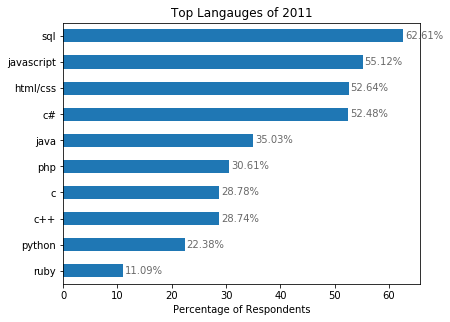

In [34]:
plot_top_values(top_langs_11, 'Top Langauges of 2011', 'Percentage of Respondents')

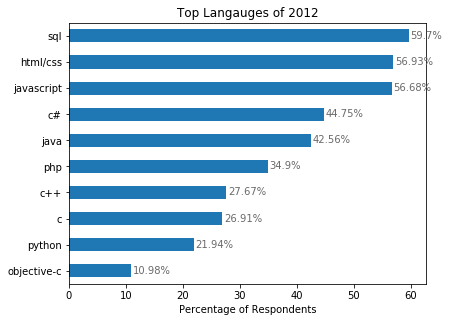

In [35]:
plot_top_values(top_langs_12, 'Top Langauges of 2012', 'Percentage of Respondents')

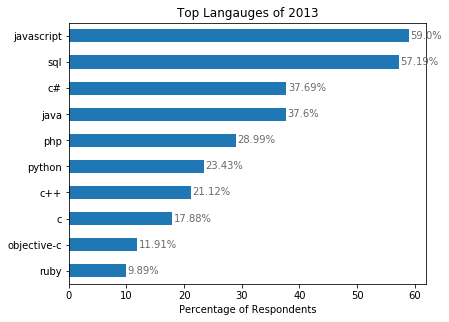

In [36]:
plot_top_values(top_langs_13, 'Top Langauges of 2013', 'Percentage of Respondents')

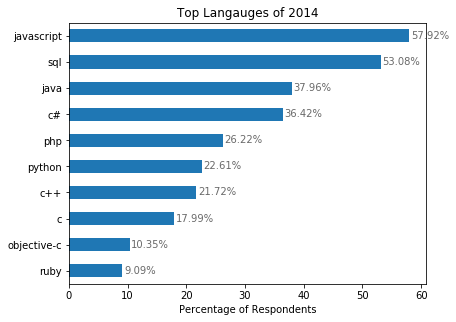

In [37]:
plot_top_values(top_langs_14, 'Top Langauges of 2014', 'Percentage of Respondents')

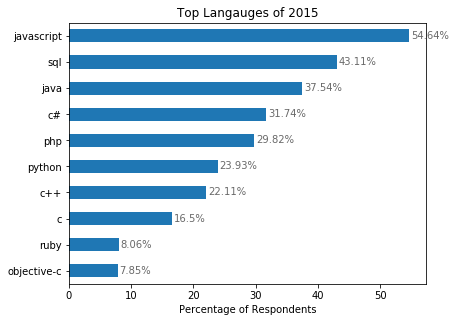

In [38]:
plot_top_values(top_langs_15, 'Top Langauges of 2015', 'Percentage of Respondents')

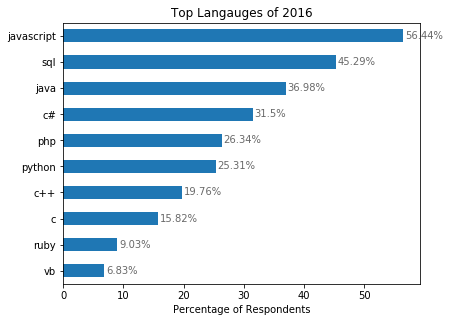

In [39]:
plot_top_values(top_langs_16, 'Top Langauges of 2016', 'Percentage of Respondents')

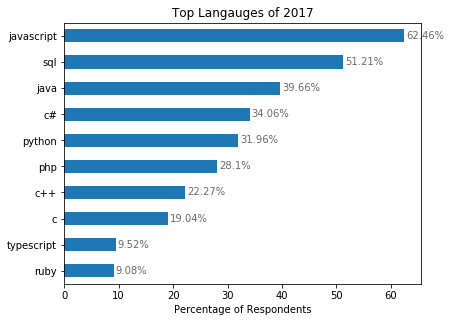

In [40]:
plot_top_values(top_langs_17, 'Top Langauges of 2017', 'Percentage of Respondents')

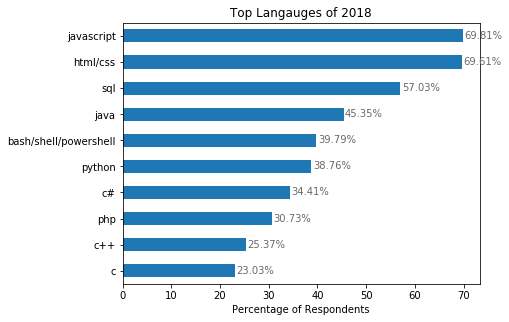

In [41]:
plot_top_values(top_langs_18, 'Top Langauges of 2018', 'Percentage of Respondents')

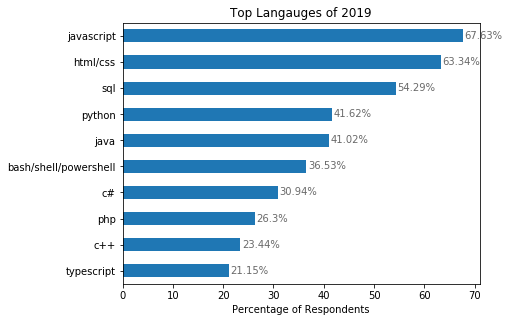

In [42]:
plot_top_values(top_langs_19, 'Top Langauges of 2019', 'Percentage of Respondents')

<img src="Images/Top Languages.png">

An interactive version of above chart is available at: https://shahzeb-akhtar.github.io/Rank_Chart/

### Job Satifaction over the years

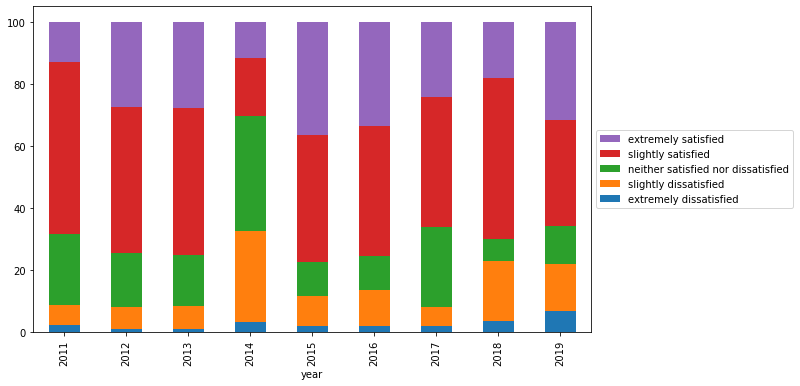

In [43]:
ax = combined_sat_data.plot(kind='bar', stacked=True, x='year', figsize=(10,6), legend=False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Languages Gaining/Losing Popularity

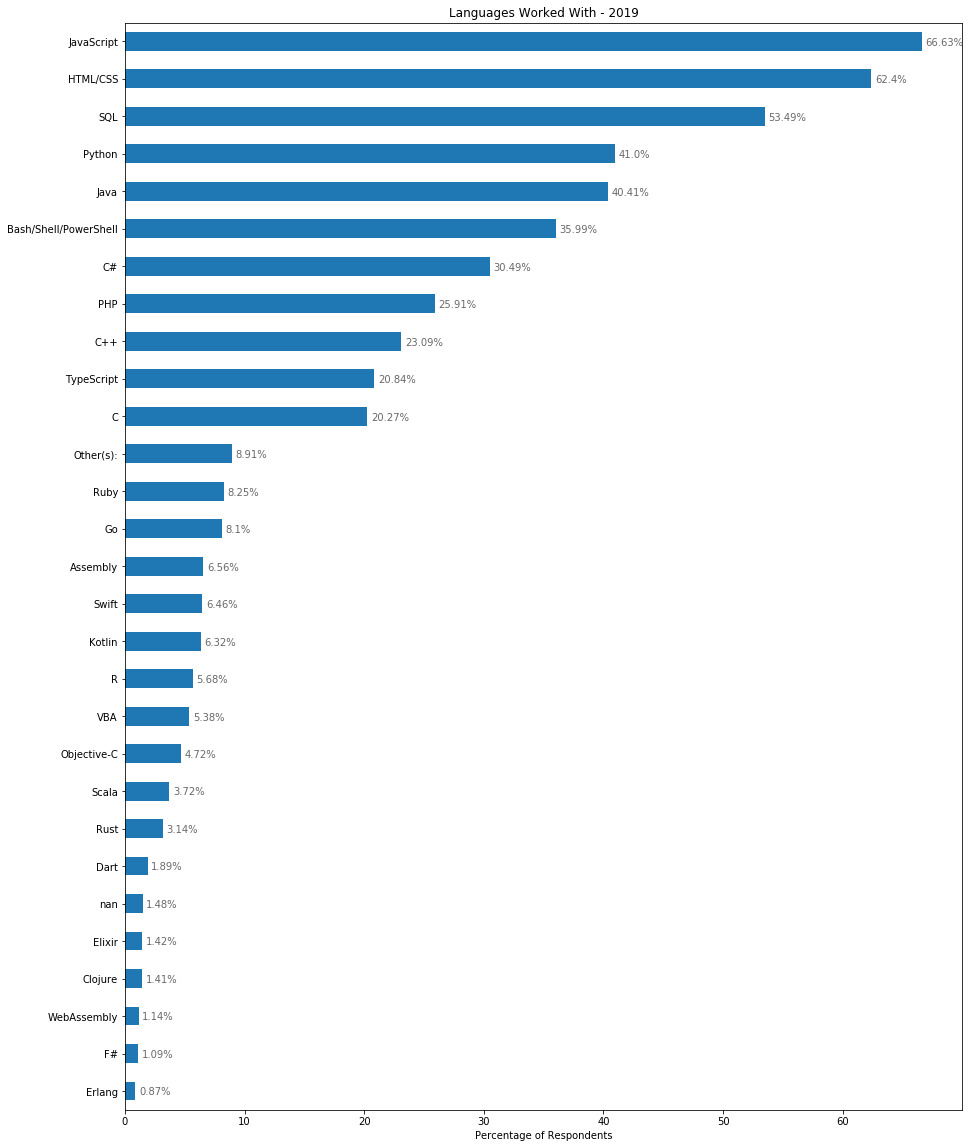

In [44]:
plot_top_values(top_lang_worked_with_19, 'Languages Worked With - 2019', 'Percentage of Respondents', '', 15, 20)

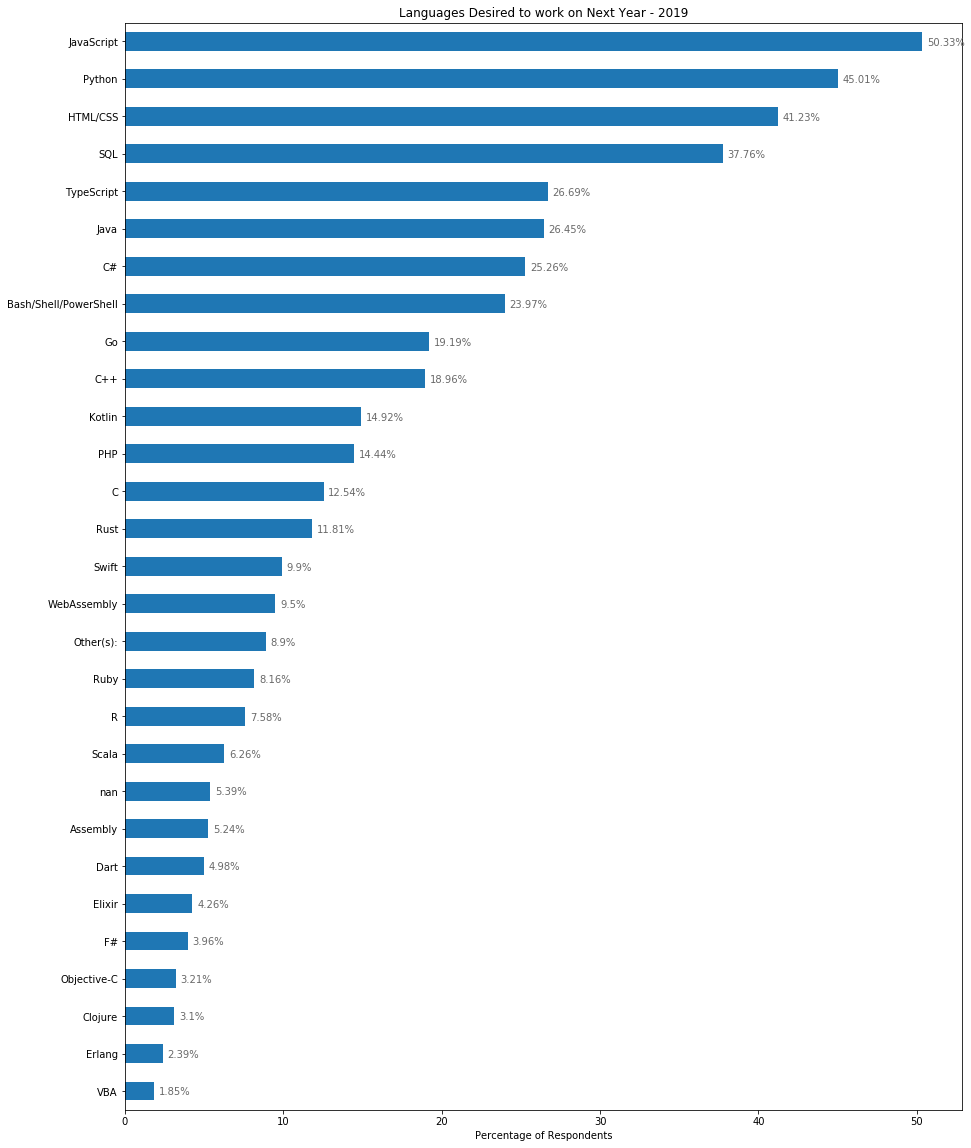

In [45]:
plot_top_values(top_lang_desired_to_work_19, 'Languages Desired to work on Next Year - 2019', 'Percentage of Respondents', \
                '', 15, 20)

<img src="Images/Languages_Comparison.png">

An interactive version of above chart is available at: https://shahzeb-akhtar.github.io/Rank_Compare/

### Database Environments Gaining/ Losing Popularity

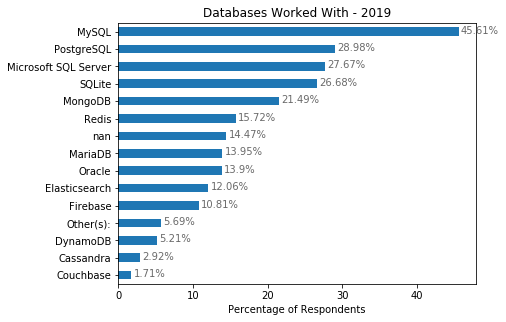

In [46]:
plot_top_values(top_database_worked_with_19, 'Databases Worked With - 2019', 'Percentage of Respondents')

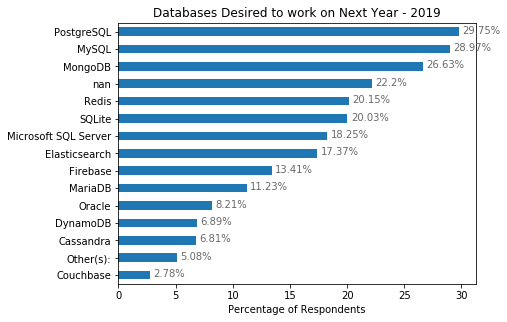

In [47]:
plot_top_values(top_database_desired_to_work_19, 'Databases Desired to work on Next Year - 2019', 'Percentage of Respondents')

<img src="Images/Databases_Comparison.png">

An interactive version of above chart is available at: https://shahzeb-akhtar.github.io/Rank_Compare/database.html

### Platforms Gaining/ Losing Popularity

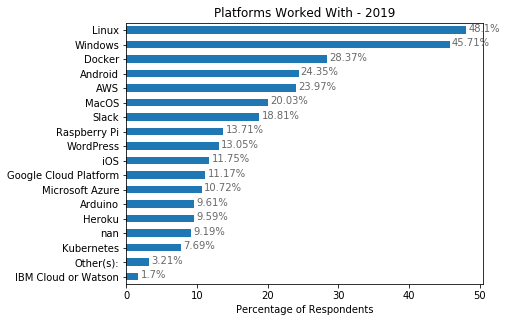

In [48]:
plot_top_values(top_platform_worked_with_19, 'Platforms Worked With - 2019', 'Percentage of Respondents')

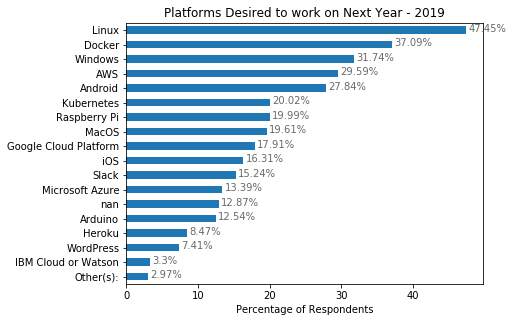

In [49]:
plot_top_values(top_platform_desired_to_work_19, 'Platforms Desired to work on Next Year - 2019', 'Percentage of Respondents')

<img src="Images/Platforms_Comparison.png">

An interactive version of above chart is available at: https://shahzeb-akhtar.github.io/Rank_Compare/platform.html

### Web Frameworks Gaining/Losing Popularity

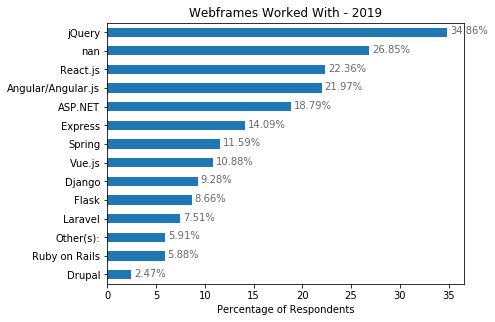

In [50]:
plot_top_values(top_webframe_worked_with_19, 'Webframes Worked With - 2019', 'Percentage of Respondents')

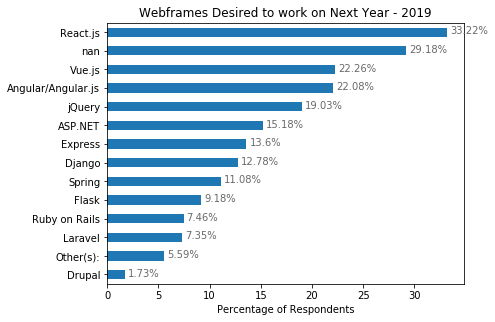

In [51]:
plot_top_values(top_webframe_desired_to_work_19, 'Webframes Desired to work on Next Year - 2019', 'Percentage of Respondents')

<img src="Images/Frameworks_Comparison.png">

An interactive version of above chart is available at: https://shahzeb-akhtar.github.io/Rank_Compare/webframe.html

## Communication of Findings

A medium article has been published at: https://medium.com/@shahzeb.akhtar/an-analysis-of-top-programming-languages-and-technologies-7eb7683941a1